In [24]:
import scipy.io
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2


In [7]:
usr = '/home/emma/Documents/PHD_work/2nd_year/Composite/'
data_dir = usr+'data/mle'
files = glob.glob(data_dir+'*results*.mat')

In [9]:
Time = 100
mle_files = [file for file in files if "T_"+str(Time) in file]
mle_files

['/home/emma/Documents/PHD_work/2nd_year/Composite/data/mlefixCHANGE_mle_allresults_T_100.mat',
 '/home/emma/Documents/PHD_work/2nd_year/Composite/data/mleext_mle_allresults_T_100.mat',
 '/home/emma/Documents/PHD_work/2nd_year/Composite/data/mlefix_mle_allresults_T_100.mat']

# Figure 9- Time-of-detection from simulated data


In [15]:
my_pal = {"true positives": "#b2df8a", "false positives 1": "#a6cee3", "false positives 2":"#8c6bb1"}

In [10]:
def matlab_to_pandas(struct):
    names = [x for x,y in sorted(mat_ext_data.dtype.fields.items(),key=lambda k: k[1])]
    d = {}
    for name in names:
        d[name] = struct[name][0][0][0]

    df = pd.DataFrame(d, index = range(500))
    return df

In [11]:
Fix_res = {}
FixChange_res = {}
Ext_res = {}
time_lengths = [100]

for time in time_lengths:
    results_t = [file for file in files if str(time) in file]
    results_ext = [file for file in results_t if 'ext' in file]
    mat = scipy.io.loadmat(results_ext[0])
    mat_ext_data = mat['data']
    
    results_fix = [file for file in results_t if 'fix_' in file]
    mat = scipy.io.loadmat(results_fix[0])
    mat_fix_data = mat['data']
    
    results_fix = [file for file in results_t if 'fixCHANGE' in file]
    mat = scipy.io.loadmat(results_fix[0])
    mat_fixChange_data = mat['data']
    
    Ext_res[str(time)] = matlab_to_pandas(mat_ext_data)
    Fix_res[str(time)] = matlab_to_pandas(mat_fix_data)
    FixChange_res[str(time)] = matlab_to_pandas(mat_fixChange_data)

In [12]:
Fix = pd.concat(Fix_res, names = ['time','run'])
FixChange = pd.concat(FixChange_res, names = ['time','run'])
Ext = pd.concat(Ext_res, names = ['time','run'])

In [13]:
Fix =Fix.reset_index()
Fix['type'] = 'false positives 1'
FixChange =FixChange.reset_index()
FixChange['type'] = 'false positives 2'
Ext =Ext.reset_index()
Ext['type'] = 'true positives'

In [14]:
both_results = pd.concat([Ext,Fix, FixChange])

/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 76.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


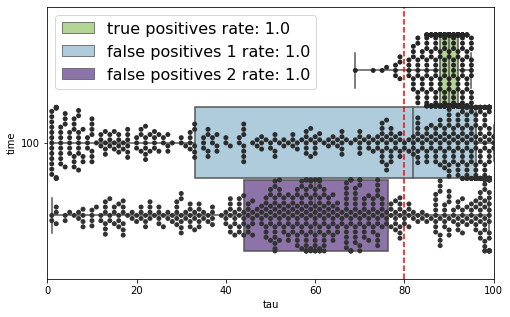

In [20]:
# No model selection
fig, ax = plt.subplots(1, figsize = (8, 5))
time = Time
select_time = both_results[both_results['time'] == str(time)]
sns.boxplot(x="tau", y = 'time', hue='type',
            data = select_time, whis=np.inf, ax = ax,palette=my_pal)
axes = sns.swarmplot(x='tau',y='time',hue='type', 
                   data =select_time, dodge = True,
                   color=".2",label='', ax = ax)
handles, labels = axes.get_legend_handles_labels()

tpr = select_time[(select_time['type']=='true positives') & (~select_time['tau'].isnull())].shape[0]/500
fpr1 =select_time[(select_time['type']=='false positives 1') & (~select_time['tau'].isnull())].shape[0]/500
fpr2 = select_time[(select_time['type']=='false positives 2') & (~select_time['tau'].isnull())].shape[0]/500
labels_rate = [l + ' rate: ' + str(r) for l, r in zip(labels[:3], [tpr, fpr1, fpr2])]
axes.legend(handles[:3], labels_rate, loc = 'upper left', fontsize = 16)
axes.set_xlim([0, time])
axes.axvline(time*0.8, color = 'r', linestyle='--', label = r'$R_0=1$') 



In [25]:
def MBIC(df, k, time):
    df = df.reset_index()
    lambda_value =( (1.5)*np.log(time)+
                   np.log(df['tau'])+
                  np.log(time-df['tau']+1))
    
    df.loc[(df['LLR']<=lambda_value),'tau'] = np.nan
    sensitivity = df[(df['type']=='true positives') & (~df['tau'].isnull())].shape[0]/500
    FPR1 =  df[(df['type']=='false positives 1') & (~df['tau'].isnull())].shape[0]/500
    FPR2 =df[(df['type']=='false positives 2') & (~df['tau'].isnull())].shape[0]/500
    return df, sensitivity, FPR1, FPR2

def wilkstheorem(df, k, time):
    df = df.reset_index()
    lambda_value = chi2.ppf(0.975, df=k)
    
    df.loc[(df['LLR']<=lambda_value),'tau'] = np.nan
    sensitivity = df[(df['type']=='true positives') & (~df['tau'].isnull())].shape[0]/500
    FPR1 =  df[(df['type']=='false positives 1') & (~df['tau'].isnull())].shape[0]/500
    FPR2 =df[(df['type']=='false positives 2') & (~df['tau'].isnull())].shape[0]/500

    return df, sensitivity, FPR1, FPR2

def AIC(df, k, time):
    df = df.reset_index()
    lambda_value = 2*k
    df.loc[(df['LLR']<=lambda_value),'tau'] = np.nan
    sensitivity = df[(df['type']=='true positives') & (~df['tau'].isnull())].shape[0]/500
    FPR1 =  df[(df['type']=='false positives 1') & (~df['tau'].isnull())].shape[0]/500
    FPR2 =df[(df['type']=='false positives 2') & (~df['tau'].isnull())].shape[0]/500

    return df, sensitivity, FPR1, FPR2

def Hannan_Quinn(df, k, time):
    df = df.reset_index()
    lambda_value = 2*k*np.log(np.log(time))
    df.loc[(df['LLR']<=lambda_value),'tau'] = np.nan
    sensitivity = df[(df['type']=='true positives') & (~df['tau'].isnull())].shape[0]/500
    FPR1 =  df[(df['type']=='false positives 1') & (~df['tau'].isnull())].shape[0]/500
    FPR2 =df[(df['type']=='false positives 2') & (~df['tau'].isnull())].shape[0]/500

    return df, sensitivity, FPR1, FPR2

def BIC(df, k, time):
    df = df.reset_index()
    lambda_value = k*np.log(time)
    df.loc[(df['LLR']<=lambda_value),'tau'] = np.nan
    sensitivity = df[(df['type']=='true positives') & (~df['tau'].isnull())].shape[0]/500
    FPR1 =  df[(df['type']=='false positives 1') & (~df['tau'].isnull())].shape[0]/500
    FPR2 =df[(df['type']=='false positives 2') & (~df['tau'].isnull())].shape[0]/500

    return df, sensitivity, FPR1, FPR2

/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 64.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 76.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 76.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 76.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/emma/anaconda3/envs/2ndphd

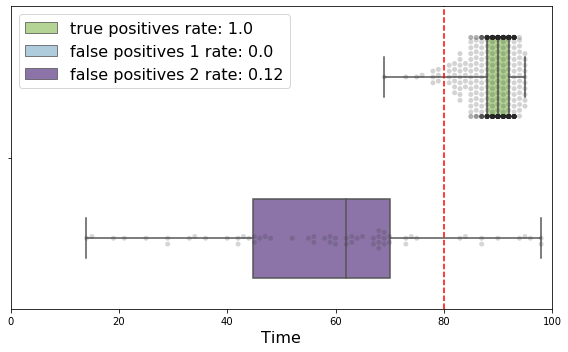

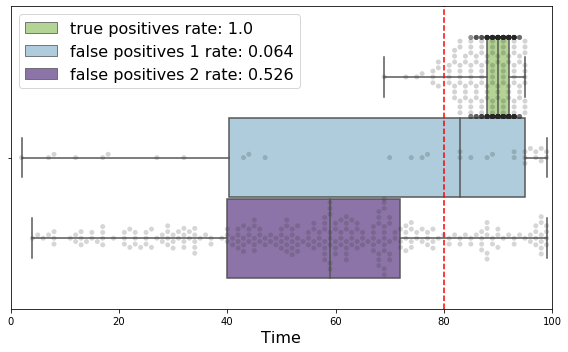

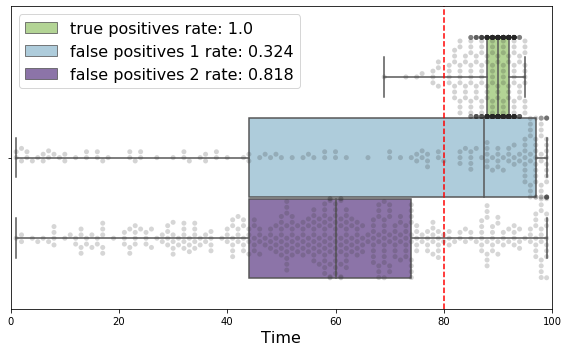

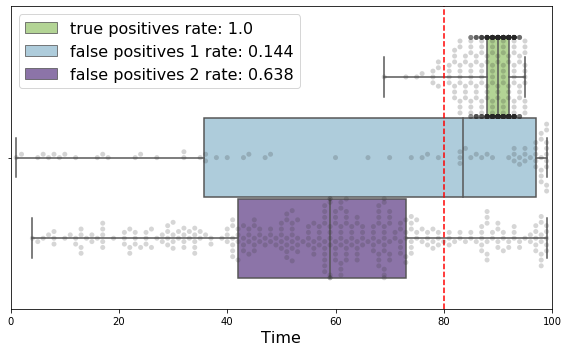

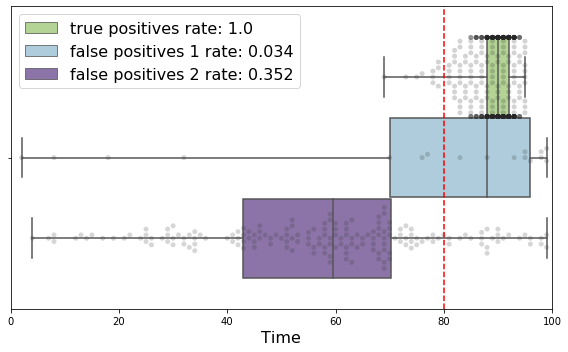

In [26]:

for model_selection in [MBIC, wilkstheorem, AIC, Hannan_Quinn, BIC]:
    fig, ax = plt.subplots(figsize = (8,5))
    select_time = both_results[both_results['time'] == str(Time)]
    df2, tpr, fpr1, fpr2 = model_selection(select_time, 2, Time)
    sns.boxplot(x="tau", y = 'time', hue='type',
                data = df2, whis=np.inf, ax = ax, palette=my_pal)
    axes = sns.swarmplot(x='tau',y='time',hue='type', 
                       data =df2, dodge = True,alpha = 0.2,
                       color=".2",label='', ax = ax)
    handles, labels = axes.get_legend_handles_labels()
    labels_rate = [l + ' rate: ' + str(r) for l, r in zip(labels[:3], [tpr, fpr1, fpr2])]

    axes.legend(handles[:3], labels_rate, loc = 'upper left', fontsize = 16)
    axes.set_xlim([0, Time])
    axes.axvline(Time*0.8, color = 'r', linestyle='--', label = r'$R_0=1$') 


    ax.set_xlim([0,Time])
    ax.set_xlabel('Time', fontsize = 16)
    ax.set(ylabel = None)
    ax.tick_params(labelleft=False)
    fig.tight_layout()
